<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Загрузка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Загрузка данных
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-Трансформерная-архитектура-GPT">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    Трансформерная архитектура GPT
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1-Токенизация-символов">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>
                            Токенизация символов
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.2-Подготовка-модели">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>
                            Подготовка модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.3-Обучение-модели">
                            <span class="toc-item-num">3.3&nbsp;&nbsp;</span>
                            Обучение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.4-Генерация-текста">
                            <span class="toc-item-num">3.4&nbsp;&nbsp;</span>
                            Генерация текста
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Генеративные текстовые нейросети | Архитектура GPT

**Постановка задачи:** натренировать и сравнить качество нескольких генеративных текстовых моделей на одном из заданных текстовых датасетов.

**Источник данных:** [Harry Potter and the Methods of Rationality](https://hpmor.ru/).

**Характер данных:** текст книги "Гарри Поттер и методы рационального мышления".

**Основные этапы:** исследовать следующие нейросетевые архитектуры:

1. Simple RNN с посимвольной и пословной токенизацией.
2. Однонаправленная однослойная и многослойная LSTM c посимвольной токенизацией и токенизацией по словам и [на основе BPE](https://keras.io/api/keras_nlp/tokenizers/byte_pair_tokenizer/).
3. Двунаправленная LSTM.
4. *(На хорошую оценку)* трансформерная архитектура (GPT) "с нуля" [пример](https://keras.io/examples/generative/text_generation_gpt/).
5. *(На отличную оценку)* дообучение предобученной GPT-сети [пример](https://github.com/ZotovaElena/RuGPT3_finetuning).

---

# Реализации

1. [RNN с посимвольной токенизацией](RNN_char.ipynb)
2. [RNN с пословной токенизацией](RNN_word.ipynb)
3. [Однонаправленная LSTM + BPE](LSTM_unidirectional_BPE.ipynb)
4. [Двунаправленная LSTM](LSTM_bidirectional.ipynb)
5. Архитектура GPT (текущий файл)
6. [Дообучение GPT](GPT_finetuning.ipynb)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Импорт библиотек:

In [1]:
from typing import Tuple

import os

import tensorflow as tf

from tensorflow import keras
from tensorflow.data import TextLineDataset, AUTOTUNE
from keras import callbacks, utils, losses

import keras.layers as l

import keras_nlp

from keras_nlp import tokenizers, samplers, metrics

# custom funcs
import utils.web_scrapping as web
import utils.process_checking as check
import utils.data_preprocessing as data_prep
import utils.charts_plotting as chart

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Загрузка данных

Формирование/загрузка набора данных в зависимости от его наличия:

In [2]:
data = web.load_data('https://hpmor.ru/', 'hpmor.txt')

Uploaded from data/hpmor.txt


Выведение на экран начала текста:

In [3]:
data[:500]

'гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду. у него были частные учителя, дискуссии с отцом, а главное — книги, сотни и тысячи научных и фантастических книг. в 11 лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами. но гарри не просто вундеркинд, у него есть загадочная тёмная сторона, которая явн'

Выведение на экран общего числа слов и предложений в тексте:

In [4]:
check.print_total(data)

Всего слов: 559791
Всего предложений: 37351


Задание путей до выборок данных:

In [5]:
path_train = 'data/hpmor_train.txt'
path_valid = 'data/hpmor_valid.txt'

Формирование тренировочной и валидационной выборок:

In [6]:
data_prep.train_valid_test_split_save(data, path_train, path_valid)

Files already exist


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Трансформерная архитектура GPT

### 3.1 Токенизация символов

Задание функции разделения данных на признаки и целевой признак:

In [7]:
def preprocess(inputs: TextLineDataset):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels

---

Выведение на экран максимальной и минимальной длины предложений в тексте:

In [8]:
check.print_max_min_len(data.split('.'))

Максимальная длина строки: 217
Минимальная длина строки: 0


Задание констант:

In [9]:
BATCH_SIZE = 64
SEQ_LEN = 128
MIN_SEQ_LEN = 450
MAX_VOCAB_LEN = 5000

Формирование датасетов:

In [10]:
train_dataset = (
    TextLineDataset(path_train)
    .filter(lambda x: tf.strings.length(x) > MIN_SEQ_LEN)
    .batch(BATCH_SIZE)
    .shuffle(buffer_size=256)
)

valid_dataset = (
    TextLineDataset(path_valid)
    .filter(lambda x: tf.strings.length(x) > MIN_SEQ_LEN)
    .batch(BATCH_SIZE)
)

Выведение на экран первого бартча тренировочного датасета:

In [11]:
list(train_dataset.as_numpy_iterator())[0][0].decode('utf-8')[:500]

'профессор макгонагалл, у которой использование маховика времени не вошло в привычку настолько, как у директора и гарри, после окончания совещания сразу же ушла спать звук шёл секунд двадцать, поэтому, наверное, минуты две на метле… движением настолько гладким, что оно казалось неосознанным, профессор макгонагалл приняла нужную позу: — экспекто патронум сгусток красного света почти в упор ударил в затылок не-сьюзен и швырнул её на пол — с ним всё в порядке, ему лишь нужен день отдыха — ты должен '

Формирование словаря:

In [12]:
vocabulary = tokenizers.compute_word_piece_vocabulary(
    train_dataset,
    vocabulary_size=MAX_VOCAB_LEN,
    lowercase=True,
    reserved_tokens=['[PAD]', '[UNK]', '[BOS]'],
)

Выведение на экран общего числа слов:

In [13]:
print('Слов в словаре:', len(vocabulary))

Слов в словаре: 4926


Выведение на экран первых элементов словаря:

In [14]:
vocabulary[:10]

['[PAD]', '[UNK]', '[BOS]', '!', '#', '$', '%', '&', '(', ')']

Формирование словаря токенов:

In [15]:
tokenizer = tokenizers.WordPieceTokenizer(
    vocabulary=vocabulary,
    sequence_length=SEQ_LEN,
    lowercase=True
)

задание объекта, формирующего токен начала строки:

In [16]:
start_packer = keras_nlp.layers.StartEndPacker(
    sequence_length=SEQ_LEN,
    start_value=tokenizer.token_to_id('[BOS]'),
)

Токенизация датасетов:

In [17]:
train = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
valid = valid_dataset.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Выведение на экран экземпляра признаков и целевого признака:

In [18]:
check.print_single_element(
    train.get_single_element()[0],
    train.get_single_element()[1],
    tokenizer.id_to_token
)

Признаки (128,):
[   2   14   14   14  697   23 3035  316  715  965    3  100  527   67
  227   12  100  614  373   12   81 2647  712 1927  134 1971 1497  179
  289 2238   12  169  124  306 4597   82  504   73  169 2440  191  280
  304  111 3728   12  100  109  111  259  276  392 1547   12  109  454
   12  158  125 1828 1601  627  417  467 1653   12  109  154 4711 2408
   82 4077  151  409 1730   80  609 3359  148 1020  209   12   65  383
  537   79  565 4321  706  127 2352 3162  168  141  161 4776  120 1469
 2071   67 3647 1246   76  151 3085  338   12   67  179 2236  579 1718
  348   12  117   65  445 4513  122   73 4791  513 3833 3093  223 1125
 2688  621]

Перевод в текст:
[BOS] . . . глава 7 ##8 вообще кому угодно ! — дело в том , — ответила минерва , р ##ас ##п ##ря ##м ##ляя пальцами до ##ку ##мент , который она при ##несла с собой и который лежал теперь перед ней на столе , — что на самом деле альбус считал , что знает , кто по ##бе ##дит волдеморта отец также добавил , что тол

---

### 3.2 Подготовка модели

Задание функции, конструирующей модель:

In [19]:
def model_construction(vocab_size: int,
                       seq_len: int,
                       embed_dim: int,
                       n_layers: int,
                       n_heads: int,
                       inter_dim: int) -> keras.Model:
    
    features = l.Input(shape=(None,), dtype=tf.int32)
    
    embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
        vocabulary_size=vocab_size,
        sequence_length=seq_len,
        embedding_dim=embed_dim,
        mask_zero=True,
    )
    
    x = embedding_layer(features)
    
    for _ in range(n_layers):
        decoder_layer = keras_nlp.layers.TransformerDecoder(
            num_heads=n_heads,
            intermediate_dim=inter_dim,
        )
        x = decoder_layer(x)
        
    target = l.Dense(vocab_size)(x)
    
    model = keras.Model(inputs=features, outputs=target)
    
    return model

---

Задание модели:

In [20]:
model = model_construction(
    vocab_size=MAX_VOCAB_LEN,
    seq_len=SEQ_LEN,
    embed_dim=256,
    n_layers=2,
    n_heads=3,
    inter_dim=256    
)

Выведение на экран таблицы поведения параметров на слоях нейросети:

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddin  (None, None, 256)        1312768   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_decoder (Transf  (None, None, 256)        394749    
 ormerDecoder)                                                   
                                                                 
 transformer_decoder_1 (Tran  (None, None, 256)        394749    
 sformerDecoder)                                                 
                                                                 
 dense (Dense)               (None, None, 5000)        128500

Проверка наличия папки для хранения изображений:

In [22]:
if os.path.isdir('images/') == False:
    os.mkdir('images/')

Выведение на экран отображения послойной обработки данных моделью:

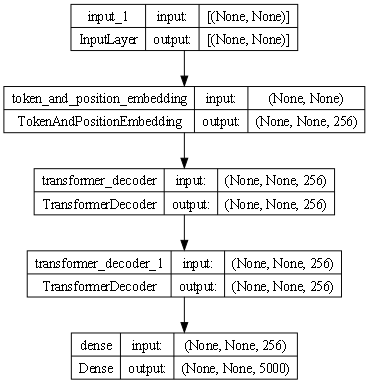

In [23]:
utils.plot_model(model, 'images/gpt_arch.png', show_shapes=True, dpi=70)

---

### 3.3 Обучение модели

Проверка наличия папки для хранения контрольных точек:

In [24]:
if os.path.isdir('checkpoints/') == False:
    os.mkdir('checkpoints/')

Задание пути для хранения контрольных точек:

In [25]:
path_checkpoints = 'checkpoints/gpt_arch'

Проверка наличия папки для хранения контрольных точек:

In [26]:
if os.path.isdir(path_checkpoints) == False:
    os.mkdir(path_checkpoints)

Задание коллбека точек сохранения:

In [27]:
checkpoint_path = os.path.join(path_checkpoints, 'checkpoint_{epoch}')

checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_weights_only=True, 
    verbose=1
)

Подготовка модели к обучению:

In [28]:
model.compile(
    optimizer='adam', 
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

Обучение модели:

In [29]:
history = model.fit(
    train, 
    validation_data=valid, 
    epochs=100, 
    verbose=2,
    callbacks=[checkpoint_callback]
)

Epoch 1/100

Epoch 1: saving model to checkpoints/gpt_arch\checkpoint_1
1/1 - 6s - loss: 8.5657 - accuracy: 3.2552e-04 - val_loss: 8.3923 - val_accuracy: 0.0191 - 6s/epoch - 6s/step
Epoch 2/100

Epoch 2: saving model to checkpoints/gpt_arch\checkpoint_2
1/1 - 2s - loss: 8.2530 - accuracy: 0.0295 - val_loss: 8.1910 - val_accuracy: 0.0512 - 2s/epoch - 2s/step
Epoch 3/100

Epoch 3: saving model to checkpoints/gpt_arch\checkpoint_3
1/1 - 2s - loss: 7.9457 - accuracy: 0.0638 - val_loss: 7.9649 - val_accuracy: 0.0512 - 2s/epoch - 2s/step
Epoch 4/100

Epoch 4: saving model to checkpoints/gpt_arch\checkpoint_4
1/1 - 2s - loss: 7.6510 - accuracy: 0.0638 - val_loss: 7.7469 - val_accuracy: 0.0512 - 2s/epoch - 2s/step
Epoch 5/100

Epoch 5: saving model to checkpoints/gpt_arch\checkpoint_5
1/1 - 2s - loss: 7.3892 - accuracy: 0.0638 - val_loss: 7.5614 - val_accuracy: 0.0512 - 2s/epoch - 2s/step
Epoch 6/100

Epoch 6: saving model to checkpoints/gpt_arch\checkpoint_6
1/1 - 2s - loss: 7.1614 - accuracy

1/1 - 2s - loss: 1.7630 - accuracy: 0.7567 - val_loss: 7.0994 - val_accuracy: 0.0755 - 2s/epoch - 2s/step
Epoch 47/100

Epoch 47: saving model to checkpoints/gpt_arch\checkpoint_47
1/1 - 2s - loss: 1.6830 - accuracy: 0.7536 - val_loss: 7.1317 - val_accuracy: 0.0694 - 2s/epoch - 2s/step
Epoch 48/100

Epoch 48: saving model to checkpoints/gpt_arch\checkpoint_48
1/1 - 2s - loss: 1.5841 - accuracy: 0.7762 - val_loss: 7.1811 - val_accuracy: 0.0651 - 2s/epoch - 2s/step
Epoch 49/100

Epoch 49: saving model to checkpoints/gpt_arch\checkpoint_49
1/1 - 2s - loss: 1.5092 - accuracy: 0.7887 - val_loss: 7.1730 - val_accuracy: 0.0720 - 2s/epoch - 2s/step
Epoch 50/100

Epoch 50: saving model to checkpoints/gpt_arch\checkpoint_50
1/1 - 2s - loss: 1.4220 - accuracy: 0.7923 - val_loss: 7.1876 - val_accuracy: 0.0747 - 2s/epoch - 2s/step
Epoch 51/100

Epoch 51: saving model to checkpoints/gpt_arch\checkpoint_51
1/1 - 2s - loss: 1.3527 - accuracy: 0.8001 - val_loss: 7.2277 - val_accuracy: 0.0668 - 2s/epoch

Epoch 92/100

Epoch 92: saving model to checkpoints/gpt_arch\checkpoint_92
1/1 - 2s - loss: 0.1849 - accuracy: 0.9855 - val_loss: 8.3509 - val_accuracy: 0.0616 - 2s/epoch - 2s/step
Epoch 93/100

Epoch 93: saving model to checkpoints/gpt_arch\checkpoint_93
1/1 - 2s - loss: 0.1764 - accuracy: 0.9871 - val_loss: 8.3737 - val_accuracy: 0.0608 - 2s/epoch - 2s/step
Epoch 94/100

Epoch 94: saving model to checkpoints/gpt_arch\checkpoint_94
1/1 - 2s - loss: 0.1692 - accuracy: 0.9873 - val_loss: 8.3718 - val_accuracy: 0.0625 - 2s/epoch - 2s/step
Epoch 95/100

Epoch 95: saving model to checkpoints/gpt_arch\checkpoint_95
1/1 - 2s - loss: 0.1631 - accuracy: 0.9878 - val_loss: 8.4085 - val_accuracy: 0.0608 - 2s/epoch - 2s/step
Epoch 96/100

Epoch 96: saving model to checkpoints/gpt_arch\checkpoint_96
1/1 - 2s - loss: 0.1563 - accuracy: 0.9878 - val_loss: 8.4195 - val_accuracy: 0.0625 - 2s/epoch - 2s/step
Epoch 97/100

Epoch 97: saving model to checkpoints/gpt_arch\checkpoint_97
1/1 - 2s - loss: 0.1

Выведение на экран графика значений функции потерь и качества модели:

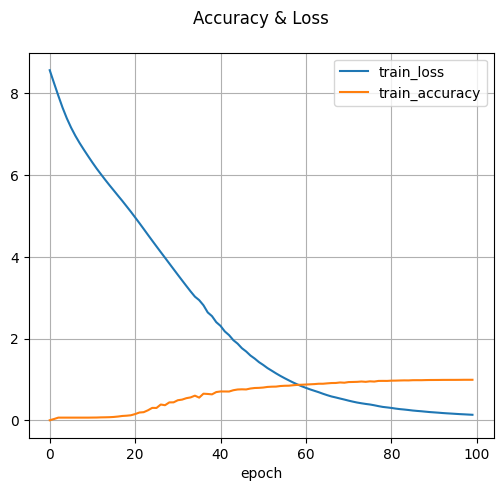

In [30]:
chart.plot_loss_acc(history)

Сброс состояния модели:

In [31]:
model.reset_states()

---

### 3.4 Генерация текста

Задание функции, заполняющей тело запроса:

In [32]:
def next(prompt: tf.Tensor, cache: tf.Tensor, index: tf.Tensor) -> Tuple[tf.Tensor, None, Tuple]:
    logits = model(prompt)[:, index - 1, :]
    hidden_states = None
    return logits, hidden_states, cache

Задание функции предсказания следующего символа:

In [33]:
def generate_text(sampler: keras_nlp.samplers) -> str:
    prompt = start_packer(tokenizer(['']))
    
    tokens = sampler(
        next=next,
        prompt=prompt,
        index=1,
    )
    
    text = tokenizer.detokenize(tokens)
    return text.numpy()[0].decode('utf-8')

---

**Greedy search** - алгоритм подбора наиболее вероятного токена на каждом шаге.

Генерация текста:

In [34]:
generate_text(samplers.GreedySampler())

'[BOS] гарри поттер ! эй , летучая мышь я упал с метлы и сломал несколько рёбер анна повторяла всё , что смогла запомнить из услышанного — сундуки , вместительность которых больше , чем кажется по их внешнему виду и малфой , и поттер знают , что они смогут победить , только если объединятся и разгромят нас , а уже потом сразятся между собой я знаю одну слизеринку , она возьмёт с тебя мерку . . . — только не говори ей , зачем это . . .'

---

**Beam search** - алгоритм подбора наиболее вероятной последовательности на каждом шаге и лучшего токена среди всех последовательностей. 

Генерация текста:

In [35]:
generate_text(samplers.BeamSampler(num_beams=10))

'[BOS] книга « думай как физик » в оригинале называется « thinking physics » драко оторвался от книги и почувствовал злорадное удовлетворение , увидев печаль на лице гарри — ладно , чтобы отнестись к этому серьёзно , мне нужно взять паузу и подумать минут пять я и сам в ваши годы был болваном , каких поискать таким маглам приходится вступать в брак тайно , и если кто - нибудь когда - нибудь узнает их секрет , то обоих сожгу'

---

**Random search** - алгоритм подбора следующего наиболее вероятного токена, которым может оказаться любое слово из всего корпуса текста, на каждом шаге.

Генерация текста:

In [36]:
generate_text(samplers.RandomSampler())

'[BOS] с джиневрой уизли гарри вытаращил глаза ) гарри пошатнулся , ощутив под ногами уличную мостовую вместо лесной тропы — надо ,вал , что поттер явно был ле еголожить в заклинание своё счастливое воспоминание , через который она увидела , было лицо профессора макгонагалл , что это мне ? ! —идя на подлокотникежусьваном , но это точнорор анне не орани дамблдора , что от , было распрадыкола трость на пару сантиметров и с силой'

---

**Top-K search** - алгоритм подбора следующего токена по вероятностному распределению, которое распределеяется между фиксированного числа топ-К наиболее вероятных токенов.

Генерация текста:

In [37]:
generate_text(samplers.TopKSampler(k=10))

'[BOS] у меня был очень тяжёлый день мозг гарри считал ластик цельным объектом , но не в понял , и нельзя было рациональности фродо пробежался взглядом по всем лицам , но никто не смотрел в его сторону его слова были записаны дословно ! — верно , — подумал гарри , по - прежнему не желая встречаться старшую палочку и прокрестил её с палочкой гермионы ( десять и три четверти дюймов вережив несколько приключений , например , посадить инвалида на'

---

**Top-P search** - алгоритм подбора следующего токена по вероятностному распределению, неравномерно распределённому среди наиболее вероятных токенов.

Генерация текста:

In [38]:
generate_text(samplers.TopPSampler(p=0.5))

'[BOS] книга « думай как физик » в оригинале называется « thinking physics » драко оторвался от книги и почувствовал злорадное удовлетворение , увидев печаль на лице гарри — ладно , чтобы отнестись к этому серьёзно , мне нужно взять паузу и подумать минут пять я и сам в ваши годы был болваном , каких поискать таким маглам приходится вступать в брак тайно , и если кто - нибудь когда - нибудь узнает их секрет , то обоих сожгу'

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

Были продемонстрированы результаты генерации текстов на основании построенной модели с применением различных алгоритмов поиска лучших токенов.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>